
**Target** : 
1.   Slightly rotate (randomly selected) images in the training dataset 


**Results** : 
1.   Parameters: 10,252
2.   Best Training accuracy: 99.22%
1.   Best Testing accuracy: 99.45%

**Analysis**:
1.  Data augmentation improved the accuracy slightly
2.  The capacity of the model can be increased further 







In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [14]:
dropout = 0.07
class MNISTNet(nn.Module):

  def __init__(self):
    super(MNISTNet, self).__init__()
    # Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout(dropout)
    ) # output_size = 28

    # CONVOLUTION BLOCK 1
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout)
    ) # output_size = 26

    

    # CONVOLUTION BLOCK 1
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout)
    ) # output_size = 24

    # TRANSITION BLOCK 1
    self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout)
    ) # output_size = 10
   
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=14, kernel_size=(1, 1), padding=1, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout(dropout)
    ) # output_size = 10

  
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=12, kernel_size=(3, 3), padding=1, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(dropout)
    ) # output_size = 10

    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(dropout)
    ) # output_size = 8

    self.convblock8 = nn.Sequential(
        nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout)
    ) # output_size = 8

    # OUTPUT BLOCK
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=7)
    ) # output_size = 1

    self.convblock9 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0,  bias = False),
      ) # output_size = 1


  def forward(self, x):
    
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.convblock8(x)
    x = self.gap(x)
    x = self.convblock9(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 26, 26]           1,152
              ReLU-6           [-1, 16, 26, 26]               0
       BatchNorm2d-7           [-1, 16, 26, 26]              32
           Dropout-8           [-1, 16, 26, 26]               0
         MaxPool2d-9           [-1, 16, 13, 13]               0
           Conv2d-10           [-1, 16, 11, 11]           2,304
             ReLU-11           [-1, 16, 11, 11]               0
      BatchNorm2d-12           [-1, 16, 11, 11]              32
          Dropout-13           [-1, 16, 11, 11]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
from torch.optim.lr_scheduler import StepLR

model =  MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.09672944992780685 Batch_id=468 Accuracy=85.50: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0892, Accuracy: 9733/10000 (97.33%)

EPOCH: 1


Loss=0.043888986110687256 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.02781624346971512 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9911/10000 (99.11%)

EPOCH: 3


Loss=0.01724841631948948 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.09283211082220078 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.08722441643476486 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.027017923071980476 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.039598315954208374 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.024639278650283813 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.10778924822807312 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.04994421824812889 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.03476545214653015 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.037921320647001266 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.04599793255329132 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.009665715508162975 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.01850070245563984 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.01617210917174816 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


Loss=0.005252390634268522 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.01952213980257511 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.051314737647771835 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]



Test set: Average loss: 0.0161, Accuracy: 9945/10000 (99.45%)



Text(0.5, 1.0, 'Test Accuracy')

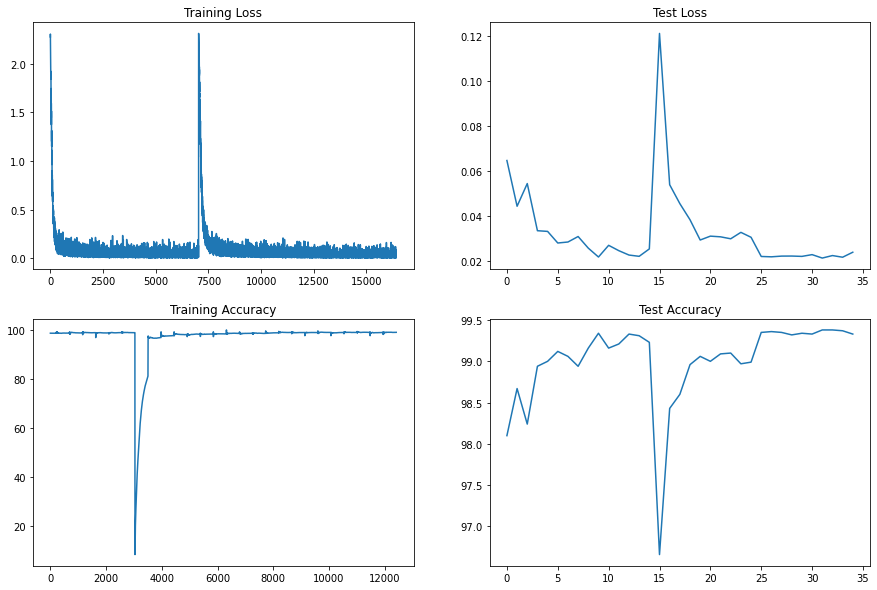

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")